<a href="https://colab.research.google.com/github/m-bashari-m/vehicle-color-recognition/blob/main/src/rgb_xyz_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/m-bashari-m/vehicle-color-recognition/main/src/utils.py

--2022-06-06 17:26:54--  https://raw.githubusercontent.com/m-bashari-m/vehicle-color-recognition/main/src/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9887 (9.7K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   9.66K  --.-KB/s    in 0s      

2022-06-06 17:26:54 (98.6 MB/s) - ‘utils.py’ saved [9887/9887]



In [2]:
from google.colab import drive
drive.mount('./drive')

Mounted at ./drive


In [3]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

!pip install -q tensorflow-io
import tensorflow_io as tfio

from utils import ModelCreator, get_train_val_ds, ErrorAnalyzer, get_class_weight

     |████████████████████████████████| 25.9 MB 80.6 MB/s 


In [4]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
AUTOTUNE = tf.data.AUTOTUNE
N_CLASSES = 16
HUB_URL = 'https://tfhub.dev/google/bit/m-r50x1/1'

In [5]:
dataset_dir = os.path.join('drive', 'MyDrive', 'cars')
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')

In [6]:
train_ds, val_ds = get_train_val_ds(train_dir, val_dir, batch_size=BATCH_SIZE, img_size=IMG_SIZE)

Found 17043 files belonging to 16 classes.
Found 3495 files belonging to 16 classes.


In [7]:
classes, class_weight = get_class_weight()

In [8]:
def combine_rgb_xyz(img_batch):
  img_batch_xyz = tfio.experimental.color.rgb_to_xyz(img_batch)
  return (img_batch + img_batch_xyz) / 2

In [9]:
train_ds = (
    train_ds.
    map(lambda img, lbl: (img/255., lbl), num_parallel_calls=AUTOTUNE).
    map(lambda img, lbl: (combine_rgb_xyz(img), lbl), num_parallel_calls=AUTOTUNE).
    prefetch(AUTOTUNE))

val_ds = (
    val_ds.
    map(lambda img, lbl: (img/255., lbl), num_parallel_calls=AUTOTUNE).
    map(lambda img, lbl: (combine_rgb_xyz(img), lbl), num_parallel_calls=AUTOTUNE).
    prefetch(AUTOTUNE))

In [10]:
rgb_xyz_creator = ModelCreator(HUB_URL, 'RGB_XYZ-model')
rgb_xyz_model = rgb_xyz_creator.make_model(img_size=IMG_SIZE)

Model: "RGB_XYZ-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 dense (Dense)               (None, 600)               1229400   
                                                                 
 dropout (Dropout)           (None, 600)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                9616      
                                                                 
Total params: 24,739,368
Trainable params: 1,239,016
Non-trainable params: 23,500,352
_________________________________________________________________


In [11]:
callbacks = rgb_xyz_creator.get_callbacks()

In [12]:
history = rgb_xyz_model.fit(train_ds,
                        callbacks=callbacks,
                        epochs=25,
                        class_weight=class_weight)

Epoch 1/25
533/533 [==============================] - 3664s 7s/step - loss: 1327.2883 - auc: 0.3555 - accuracy: 0.5368
Epoch 2/25
533/533 [==============================] - 197s 366ms/step - loss: 1579.3336 - auc: 0.4610 - accuracy: 0.6359
Epoch 3/25
533/533 [==============================] - 199s 370ms/step - loss: 1329.1544 - auc: 0.5445 - accuracy: 0.7045
Epoch 4/25
533/533 [==============================] - 195s 363ms/step - loss: 1195.9619 - auc: 0.5679 - accuracy: 0.7210
Epoch 5/25
533/533 [==============================] - 200s 373ms/step - loss: 943.9908 - auc: 0.5974 - accuracy: 0.7432
Epoch 6/25
533/533 [==============================] - 195s 364ms/step - loss: 811.6707 - auc: 0.6275 - accuracy: 0.7645
Epoch 7/25
533/533 [==============================] - 193s 359ms/step - loss: 660.4785 - auc: 0.6481 - accuracy: 0.7792
Epoch 8/25
533/533 [==============================] - 194s 360ms/step - loss: 540.9615 - auc: 0.6609 - accuracy: 0.7862
Epoch 9/25
533/533 [==================

In [13]:
rgb_xyz_model.save('./drive/MyDrive/checkpoints/rgb-xyz-model-25.h5')

In [14]:
analyzer = ErrorAnalyzer(model=rgb_xyz_model,
                         ds=val_ds,
                         classes=classes,
                         model_name='RGB-XYZ-model-1')

Making confusion matrix:


  0%|          | 0/55 [00:00<?, ?it/s]

Confusion matrix is saved


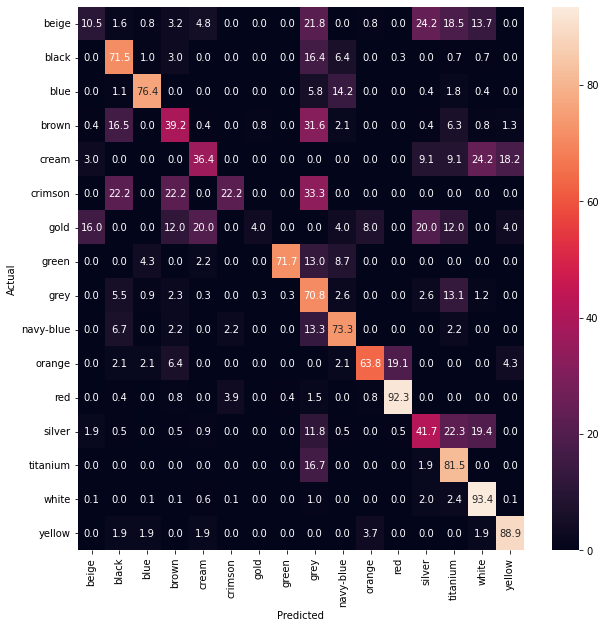

In [15]:
analyzer.plot_confusion_mat()

In [16]:
analyzer.evaluate_model()

Calculateing error types...
Writing in log file...
 All done. Check log file => RGB-XYZ-model-1.csv
Accuracy: %75.62
Precision mean: 0.6010625
Recall mean: 0.5859999999999999


In [ ]:
history =rgb_xyz_model.fit(train_ds,
                        callbacks=callbacks,
                        epochs=40,
                        initial_epoch=25,
                        class_weight=class_weight)

Epoch 26/40
533/533 [==============================] - 213s 394ms/step - loss: 45.1839 - auc: 0.8488 - accuracy: 0.9010
Epoch 27/40
533/533 [==============================] - 203s 379ms/step - loss: 44.0040 - auc: 0.8548 - accuracy: 0.9025
Epoch 28/40
467/533 [=========================>....] - ETA: 27s - loss: 34.4819 - auc: 0.8698 - accuracy: 0.9111

In [ ]:
rgb_xyz_model.save_weights('drive/MyDrive/checkpoints/rgb-xyz-model-40.h5')

Making confusion matrix:


  0%|          | 0/55 [00:00<?, ?it/s]

Saving confusion matrix


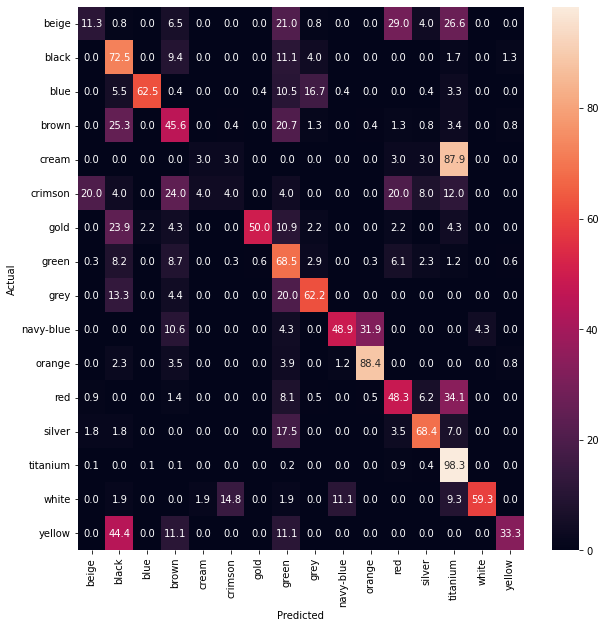

Calculating error types...
Writing in log file...
 All done. Check log file => XYZ-model-2.csv


In [ ]:
analyzer = ErrorAnalyzer(model=rgb_xyz_model,
                         ds=val_ds,
                         classes=classes,
                         model_name='RGB-XYZ-model-2')

analyzer.plot_confusion_mat()
analyzer.evaluate_model()